In [1]:
import optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

# local Module
import pre_processing_funcs as pre

In [198]:
df = pd.read_csv("data/train_data_cleaned.csv")
df.head()

,Promotion Name,Store Kind,Store Sales,Store Cost,Is Recyclable?,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,...,Store Code,Country ISO2,Order Brand,Order,Department,Amenities Score,Gross Weight,Net Weight,Package Weight,Min. Person Yearly Income
0,Dimes Off,Deluxe,8760000.00,4292400.00,yes,2842.23,2037.64,481.98,323.00,602.76,...,H11go,ZA,Red Wing,Cleaning Supplies,Household,5,28.20,26.60,1.60,10000.00
1,Budget Bargains,Supermarket,6360000.00,1971600.00,no,2814.95,2049.72,457.36,304.98,708.66,...,S04ne,WA,Nationeel,Snack Foods,Snack Foods,0,16.57,14.97,1.60,50000.00
2,Shelf Emptiers,Supermarket,10860000.00,4452600.00,yes,2192.32,1322.21,523.32,348.85,564.26,...,L05es,CA,Excel,Magazines,Periodicals,1,28.64,27.18,1.45,30000.00
3,Sale Winners,Deluxe,11560000.00,4970800.00,no,2862.30,1872.19,593.93,395.95,519.76,...,M10da,YU,Hermanos,Vegetables,Produce,5,12.62,9.71,2.91,50000.00
4,Weekend Discount,Supermarket,5220000.00,1618200.00,yes,1970.17,1236.07,440.92,293.95,364.16,...,S03le,WA,Red Wing,Candles,Household,1,15.41,13.95,1.45,30000.00


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28218 entries, 0 to 28217
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Promotion Name             28218 non-null  object 
 1   Store Kind                 28218 non-null  object 
 2   Store Sales                28218 non-null  float64
 3   Store Cost                 28218 non-null  float64
 4   Is Recyclable?             28218 non-null  object 
 5   Store Area                 28218 non-null  float64
 6   Grocery Area               28218 non-null  float64
 7   Frozen Area                28218 non-null  float64
 8   Meat Area                  28218 non-null  float64
 9   Cost                       28218 non-null  float64
 10  Degree Work                28218 non-null  object 
 11  Marriage                   28218 non-null  object 
 12  Gender                     28218 non-null  object 
 13  Children                   28218 non-null  obj

In [200]:
print(df.shape)
df.head()

(28218, 26)


,Promotion Name,Store Kind,Store Sales,Store Cost,Is Recyclable?,Store Area,Grocery Area,Frozen Area,Meat Area,Cost,...,Store Code,Country ISO2,Order Brand,Order,Department,Amenities Score,Gross Weight,Net Weight,Package Weight,Min. Person Yearly Income
0,Dimes Off,Deluxe,8760000.00,4292400.00,yes,2842.23,2037.64,481.98,323.00,602.76,...,H11go,ZA,Red Wing,Cleaning Supplies,Household,5,28.20,26.60,1.60,10000.00
1,Budget Bargains,Supermarket,6360000.00,1971600.00,no,2814.95,2049.72,457.36,304.98,708.66,...,S04ne,WA,Nationeel,Snack Foods,Snack Foods,0,16.57,14.97,1.60,50000.00
2,Shelf Emptiers,Supermarket,10860000.00,4452600.00,yes,2192.32,1322.21,523.32,348.85,564.26,...,L05es,CA,Excel,Magazines,Periodicals,1,28.64,27.18,1.45,30000.00
3,Sale Winners,Deluxe,11560000.00,4970800.00,no,2862.30,1872.19,593.93,395.95,519.76,...,M10da,YU,Hermanos,Vegetables,Produce,5,12.62,9.71,2.91,50000.00
4,Weekend Discount,Supermarket,5220000.00,1618200.00,yes,1970.17,1236.07,440.92,293.95,364.16,...,S03le,WA,Red Wing,Candles,Household,1,15.41,13.95,1.45,30000.00


In [201]:
df.isna().sum()

Promotion Name               0
Store Kind                   0
Store Sales                  0
Store Cost                   0
Is Recyclable?               0
Store Area                   0
Grocery Area                 0
Frozen Area                  0
Meat Area                    0
Cost                         0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Gross Weight                 0
Net Weight                   0
Package Weight               0
Min. Person Yearly Income    0
dtype: int64

In [254]:
df["Store CountryISO2"] = df["Store Code"] + '_' + df["Country ISO2"]

In [255]:
df['Income Level'] = (
    pd.cut(
        df['Min. Person Yearly Income'],
        bins=[0, 25000, 50000, float('inf')],
        labels=['Low', 'Middle', 'High']
    )
)

In [256]:
df['Promotion Name Length'] = df['Promotion Name'].apply(lambda x: len(x))
df['Promotion Name Length'] = df['Promotion Name Length'].astype(int)

In [257]:
promotion_frequency = df['Promotion Name'].value_counts().reset_index()
promotion_frequency.columns = ['Promotion Name', 'Promotion Frequency']
test = df.merge(promotion_frequency, on='Promotion Name', how='left')

In [228]:
target = "Cost"
X = df.drop(columns=target)
y = df[target]

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [230]:
ord_categorical_columns = df.select_dtypes("object").drop(columns=['Marriage', 'Gender', "Store CountryISO2"]).columns

hot_categorical_columns = ['Marriage', 'Gender', 'Is Recyclable?', "Income Level"]

numeric_columns = X.select_dtypes("float").columns

In [231]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), ord_categorical_columns),
        ('ohe', OneHotEncoder(), hot_categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

In [232]:
model = make_pipeline(
    preprocessor,
    DecisionTreeRegressor(max_depth=16, random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Is Recyclable?', 'Degree Work',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Meat Area', 'Gross Weight',
       'Package Weight', 'Min. Person Yearly Income'],
      dtype='object'))])),
                ('decisiontreeregressor',
                 DecisionTre

In [233]:
# Check if the model fitted well or not
predictions = model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

33.47950059701794

In [234]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

63.42181437665818

In [235]:
rfmodel = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=18, n_jobs=-1, random_state=42)
)
rfmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Is Recyclable?', 'Degree Work',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Meat Area', 'Gross Weight',
       'Package Weight', 'Min. Person Yearly Income'],
      dtype='object'))])),
                ('randomforestregressor',
                 RandomFores

In [236]:
# Check if the model fitted well or not
predictions = rfmodel.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

23.9096820624614

In [237]:
predictions = rfmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

52.00064785019391

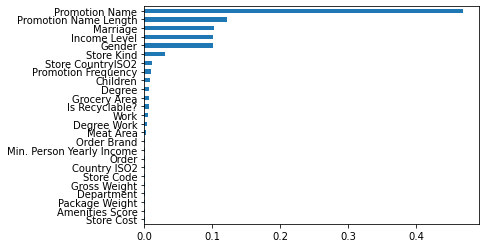

In [238]:
pd.Series(rfmodel.named_steps["randomforestregressor"].feature_importances_,
         index=X_train.columns[:25]).sort_values().plot(kind="barh");

In [239]:
exmodel = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=18, n_jobs=-1, random_state=42)
)
exmodel.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Is Recyclable?', 'Degree Work',
       'Children', 'Degree', 'Work', 'Store Code', 'Country ISO2',
       'Order Brand', 'Order', 'Department'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level']),
                                                 ('num', StandardScaler(),
                                                  Index(['Store Cost', 'Grocery Area', 'Meat Area', 'Gross Weight',
       'Package Weight', 'Min. Person Yearly Income'],
      dtype='object'))])),
                ('extratreesregressor',
                 ExtraTreesReg

In [240]:
# Check if the model fitted well or not
predictions = exmodel.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

13.560555380860126

In [241]:
predictions = exmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

46.39353917609783

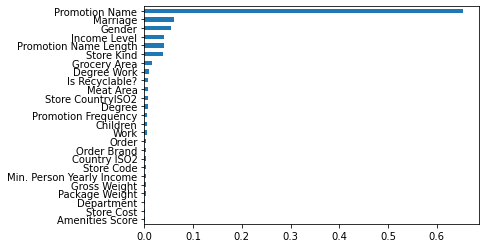

In [242]:
pd.Series(exmodel.named_steps["extratreesregressor"].feature_importances_,
         index=X_train.columns[:25]).sort_values().plot(kind="barh");

In [243]:
cat = CatBoostRegressor(
    iterations=1000,
    random_state=42,
    loss_function='RMSE',
)
cat.fit(
    X_train,
    y_train,
    cat_features=list((list(X_train.select_dtypes("object").columns)+["Income Level"])),
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.083064
0:	learn: 148.1718697	test: 148.2609019	best: 148.2609019 (0)	total: 186ms	remaining: 3m 5s
1:	learn: 140.6559586	test: 140.6650842	best: 140.6650842 (1)	total: 264ms	remaining: 2m 11s
2:	learn: 133.9310667	test: 133.7922572	best: 133.7922572 (2)	total: 424ms	remaining: 2m 20s
3:	learn: 127.6983858	test: 127.5214762	best: 127.5214762 (3)	total: 512ms	remaining: 2m 7s
4:	learn: 121.9650967	test: 121.6289622	best: 121.6289622 (4)	total: 662ms	remaining: 2m 11s
5:	learn: 116.9579191	test: 116.4805682	best: 116.4805682 (5)	total: 793ms	remaining: 2m 11s
6:	learn: 112.1660533	test: 111.6941220	best: 111.6941220 (6)	total: 880ms	remaining: 2m 4s
7:	learn: 108.0624271	test: 107.5629109	best: 107.5629109 (7)	total: 1.05s	remaining: 2m 10s
8:	learn: 104.2674178	test: 103.7336266	best: 103.7336266 (8)	total: 1.1s	remaining: 2m 1s
9:	learn: 101.0283620	test: 100.4061190	best: 100.4061190 (9)	total: 1.26s	remaining: 2m 4s
10:	learn: 98.5193405	test: 97.8596966	best: 9

90:	learn: 60.7348636	test: 59.4257365	best: 59.4257365 (90)	total: 12.1s	remaining: 2m
91:	learn: 60.7226671	test: 59.4290343	best: 59.4257365 (90)	total: 12.1s	remaining: 1m 59s
92:	learn: 60.6818793	test: 59.3827050	best: 59.3827050 (92)	total: 12.3s	remaining: 1m 59s
93:	learn: 60.5751238	test: 59.2810502	best: 59.2810502 (93)	total: 12.4s	remaining: 1m 59s
94:	learn: 60.5057733	test: 59.2014138	best: 59.2014138 (94)	total: 12.6s	remaining: 1m 59s
95:	learn: 60.5052822	test: 59.2014030	best: 59.2014030 (95)	total: 12.6s	remaining: 1m 59s
96:	learn: 60.4970802	test: 59.2012381	best: 59.2012381 (96)	total: 12.8s	remaining: 1m 58s
97:	learn: 60.3929146	test: 59.0741302	best: 59.0741302 (97)	total: 12.8s	remaining: 1m 58s
98:	learn: 60.2430672	test: 58.9196844	best: 58.9196844 (98)	total: 13s	remaining: 1m 58s
99:	learn: 60.1636535	test: 58.8000588	best: 58.8000588 (99)	total: 13.2s	remaining: 1m 58s
100:	learn: 60.1575053	test: 58.8000030	best: 58.8000030 (100)	total: 13.3s	remaining:

179:	learn: 57.2692108	test: 56.1432306	best: 56.1432306 (179)	total: 23.3s	remaining: 1m 45s
180:	learn: 57.2631287	test: 56.1431267	best: 56.1431267 (180)	total: 23.4s	remaining: 1m 45s
181:	learn: 57.2342896	test: 56.1099852	best: 56.1099852 (181)	total: 23.5s	remaining: 1m 45s
182:	learn: 57.2278236	test: 56.1102431	best: 56.1099852 (181)	total: 23.7s	remaining: 1m 45s
183:	learn: 57.2232388	test: 56.1102753	best: 56.1099852 (181)	total: 23.8s	remaining: 1m 45s
184:	learn: 57.2195742	test: 56.1070315	best: 56.1070315 (184)	total: 24s	remaining: 1m 45s
185:	learn: 57.2153411	test: 56.1070786	best: 56.1070315 (184)	total: 24.1s	remaining: 1m 45s
186:	learn: 57.2037849	test: 56.1054522	best: 56.1054522 (186)	total: 24.2s	remaining: 1m 45s
187:	learn: 57.1220890	test: 56.0366777	best: 56.0366777 (187)	total: 24.3s	remaining: 1m 45s
188:	learn: 57.0565120	test: 55.9759679	best: 55.9759679 (188)	total: 24.5s	remaining: 1m 45s
189:	learn: 57.0144969	test: 55.9471888	best: 55.9471888 (189)

267:	learn: 55.3412607	test: 54.7864644	best: 54.7856414 (266)	total: 35.4s	remaining: 1m 36s
268:	learn: 55.3229572	test: 54.7843618	best: 54.7843618 (268)	total: 35.6s	remaining: 1m 36s
269:	learn: 55.3177368	test: 54.7826533	best: 54.7826533 (269)	total: 35.8s	remaining: 1m 36s
270:	learn: 55.3065486	test: 54.7789421	best: 54.7789421 (270)	total: 35.9s	remaining: 1m 36s
271:	learn: 55.2956446	test: 54.7670957	best: 54.7670957 (271)	total: 36.1s	remaining: 1m 36s
272:	learn: 55.2207641	test: 54.6933831	best: 54.6933831 (272)	total: 36.2s	remaining: 1m 36s
273:	learn: 55.2100015	test: 54.6856638	best: 54.6856638 (273)	total: 36.3s	remaining: 1m 36s
274:	learn: 55.1713397	test: 54.6386948	best: 54.6386948 (274)	total: 36.5s	remaining: 1m 36s
275:	learn: 55.1506373	test: 54.6226249	best: 54.6226249 (275)	total: 36.6s	remaining: 1m 35s
276:	learn: 55.0731005	test: 54.6305059	best: 54.6226249 (275)	total: 36.8s	remaining: 1m 36s
277:	learn: 55.0623649	test: 54.6361683	best: 54.6226249 (27

356:	learn: 53.1182906	test: 53.2240777	best: 53.2237711 (355)	total: 48.6s	remaining: 1m 27s
357:	learn: 53.0687296	test: 53.2149730	best: 53.2149730 (357)	total: 48.7s	remaining: 1m 27s
358:	learn: 53.0468099	test: 53.2043552	best: 53.2043552 (358)	total: 48.8s	remaining: 1m 27s
359:	learn: 52.9969168	test: 53.2375700	best: 53.2043552 (358)	total: 49s	remaining: 1m 27s
360:	learn: 52.9842577	test: 53.2222385	best: 53.2043552 (358)	total: 49.1s	remaining: 1m 26s
361:	learn: 52.9511440	test: 53.1729976	best: 53.1729976 (361)	total: 49.3s	remaining: 1m 26s
362:	learn: 52.9359612	test: 53.1719092	best: 53.1719092 (362)	total: 49.4s	remaining: 1m 26s
363:	learn: 52.9326373	test: 53.1716691	best: 53.1716691 (363)	total: 49.6s	remaining: 1m 26s
364:	learn: 52.9269377	test: 53.1712553	best: 53.1712553 (364)	total: 49.7s	remaining: 1m 26s
365:	learn: 52.9201034	test: 53.1715711	best: 53.1712553 (364)	total: 49.9s	remaining: 1m 26s
366:	learn: 52.9067311	test: 53.1497978	best: 53.1497978 (366)

445:	learn: 51.7241650	test: 52.5406859	best: 52.5406859 (445)	total: 1m 1s	remaining: 1m 15s
446:	learn: 51.7182385	test: 52.5404363	best: 52.5404363 (446)	total: 1m 1s	remaining: 1m 15s
447:	learn: 51.7111730	test: 52.5312908	best: 52.5312908 (447)	total: 1m 1s	remaining: 1m 15s
448:	learn: 51.6956748	test: 52.5302269	best: 52.5302269 (448)	total: 1m 1s	remaining: 1m 15s
449:	learn: 51.6891238	test: 52.5315040	best: 52.5302269 (448)	total: 1m 1s	remaining: 1m 15s
450:	learn: 51.6856770	test: 52.5314432	best: 52.5302269 (448)	total: 1m 1s	remaining: 1m 15s
451:	learn: 51.6623027	test: 52.5050565	best: 52.5050565 (451)	total: 1m 2s	remaining: 1m 15s
452:	learn: 51.6585403	test: 52.5037539	best: 52.5037539 (452)	total: 1m 2s	remaining: 1m 15s
453:	learn: 51.6547383	test: 52.5043447	best: 52.5037539 (452)	total: 1m 2s	remaining: 1m 14s
454:	learn: 51.6514298	test: 52.5048793	best: 52.5037539 (452)	total: 1m 2s	remaining: 1m 14s
455:	learn: 51.6480874	test: 52.4990179	best: 52.4990179 (45

534:	learn: 50.4257464	test: 51.6212223	best: 51.6212223 (534)	total: 1m 14s	remaining: 1m 4s
535:	learn: 50.4158421	test: 51.6151659	best: 51.6151659 (535)	total: 1m 14s	remaining: 1m 4s
536:	learn: 50.3737093	test: 51.5993811	best: 51.5993811 (536)	total: 1m 14s	remaining: 1m 4s
537:	learn: 50.3719605	test: 51.5990343	best: 51.5990343 (537)	total: 1m 14s	remaining: 1m 4s
538:	learn: 50.3648192	test: 51.5986950	best: 51.5986950 (538)	total: 1m 15s	remaining: 1m 4s
539:	learn: 50.3585006	test: 51.5986026	best: 51.5986026 (539)	total: 1m 15s	remaining: 1m 4s
540:	learn: 50.3511018	test: 51.5982602	best: 51.5982602 (540)	total: 1m 15s	remaining: 1m 4s
541:	learn: 50.3346143	test: 51.5934886	best: 51.5934886 (541)	total: 1m 15s	remaining: 1m 3s
542:	learn: 50.3232928	test: 51.5893358	best: 51.5893358 (542)	total: 1m 15s	remaining: 1m 3s
543:	learn: 50.3210804	test: 51.5887206	best: 51.5887206 (543)	total: 1m 15s	remaining: 1m 3s
544:	learn: 50.3045777	test: 51.5892399	best: 51.5887206 (54

623:	learn: 49.4004328	test: 51.2066867	best: 51.2019769 (619)	total: 1m 28s	remaining: 53.4s
624:	learn: 49.3898698	test: 51.1968566	best: 51.1968566 (624)	total: 1m 28s	remaining: 53.3s
625:	learn: 49.3553803	test: 51.1689329	best: 51.1689329 (625)	total: 1m 29s	remaining: 53.2s
626:	learn: 49.3496851	test: 51.1696825	best: 51.1689329 (625)	total: 1m 29s	remaining: 53s
627:	learn: 49.3408841	test: 51.1689100	best: 51.1689100 (627)	total: 1m 29s	remaining: 52.9s
628:	learn: 49.3056924	test: 51.1726548	best: 51.1689100 (627)	total: 1m 29s	remaining: 52.7s
629:	learn: 49.2978132	test: 51.1721676	best: 51.1689100 (627)	total: 1m 29s	remaining: 52.6s
630:	learn: 49.2966177	test: 51.1728062	best: 51.1689100 (627)	total: 1m 30s	remaining: 52.7s
631:	learn: 49.2922357	test: 51.1741932	best: 51.1689100 (627)	total: 1m 30s	remaining: 52.6s
632:	learn: 49.2859612	test: 51.1605090	best: 51.1605090 (632)	total: 1m 30s	remaining: 52.5s
633:	learn: 49.2661216	test: 51.1482068	best: 51.1482068 (633)

711:	learn: 48.3866326	test: 50.6802587	best: 50.6802587 (711)	total: 1m 43s	remaining: 42s
712:	learn: 48.3848905	test: 50.6807097	best: 50.6802587 (711)	total: 1m 43s	remaining: 41.8s
713:	learn: 48.3836649	test: 50.6806524	best: 50.6802587 (711)	total: 1m 44s	remaining: 41.7s
714:	learn: 48.3666284	test: 50.6737814	best: 50.6737814 (714)	total: 1m 44s	remaining: 41.6s
715:	learn: 48.3498166	test: 50.6777647	best: 50.6737814 (714)	total: 1m 44s	remaining: 41.4s
716:	learn: 48.3470098	test: 50.6772476	best: 50.6737814 (714)	total: 1m 44s	remaining: 41.3s
717:	learn: 48.3126970	test: 50.6499376	best: 50.6499376 (717)	total: 1m 44s	remaining: 41.1s
718:	learn: 48.3118282	test: 50.6501463	best: 50.6499376 (717)	total: 1m 44s	remaining: 41s
719:	learn: 48.3094996	test: 50.6498820	best: 50.6498820 (719)	total: 1m 45s	remaining: 40.8s
720:	learn: 48.3059990	test: 50.6520355	best: 50.6498820 (719)	total: 1m 45s	remaining: 40.7s
721:	learn: 48.2739479	test: 50.6169691	best: 50.6169691 (721)	t

800:	learn: 47.5148979	test: 50.1661191	best: 50.1654418 (794)	total: 1m 58s	remaining: 29.4s
801:	learn: 47.5073836	test: 50.1652008	best: 50.1652008 (801)	total: 1m 58s	remaining: 29.2s
802:	learn: 47.4999435	test: 50.1647157	best: 50.1647157 (802)	total: 1m 58s	remaining: 29.1s
803:	learn: 47.4946010	test: 50.1670176	best: 50.1647157 (802)	total: 1m 58s	remaining: 28.9s
804:	learn: 47.4909415	test: 50.1700323	best: 50.1647157 (802)	total: 1m 58s	remaining: 28.8s
805:	learn: 47.4907934	test: 50.1700369	best: 50.1647157 (802)	total: 1m 59s	remaining: 28.6s
806:	learn: 47.4736580	test: 50.1627222	best: 50.1627222 (806)	total: 1m 59s	remaining: 28.5s
807:	learn: 47.4567960	test: 50.1643814	best: 50.1627222 (806)	total: 1m 59s	remaining: 28.3s
808:	learn: 47.4411892	test: 50.1497099	best: 50.1497099 (808)	total: 1m 59s	remaining: 28.2s
809:	learn: 47.4394597	test: 50.1490669	best: 50.1490669 (809)	total: 1m 59s	remaining: 28s
810:	learn: 47.4343603	test: 50.1478429	best: 50.1478429 (810)

889:	learn: 46.6847909	test: 49.7151224	best: 49.7151224 (889)	total: 2m 11s	remaining: 16.2s
890:	learn: 46.6589290	test: 49.7037435	best: 49.7037435 (890)	total: 2m 11s	remaining: 16.1s
891:	learn: 46.6307109	test: 49.6779681	best: 49.6779681 (891)	total: 2m 11s	remaining: 16s
892:	learn: 46.6096797	test: 49.6639555	best: 49.6639555 (892)	total: 2m 11s	remaining: 15.8s
893:	learn: 46.5694048	test: 49.6573899	best: 49.6573899 (893)	total: 2m 12s	remaining: 15.7s
894:	learn: 46.5667018	test: 49.6569679	best: 49.6569679 (894)	total: 2m 12s	remaining: 15.5s
895:	learn: 46.5610738	test: 49.6554919	best: 49.6554919 (895)	total: 2m 12s	remaining: 15.4s
896:	learn: 46.5567748	test: 49.6546740	best: 49.6546740 (896)	total: 2m 12s	remaining: 15.2s
897:	learn: 46.5562246	test: 49.6546346	best: 49.6546346 (897)	total: 2m 12s	remaining: 15.1s
898:	learn: 46.5518556	test: 49.6505355	best: 49.6505355 (898)	total: 2m 12s	remaining: 14.9s
899:	learn: 46.5352481	test: 49.6483499	best: 49.6483499 (899)

977:	learn: 45.8115015	test: 49.5675153	best: 49.5573972 (960)	total: 2m 25s	remaining: 3.28s
978:	learn: 45.8044124	test: 49.5671624	best: 49.5573972 (960)	total: 2m 26s	remaining: 3.13s
979:	learn: 45.8035294	test: 49.5666836	best: 49.5573972 (960)	total: 2m 26s	remaining: 2.98s
980:	learn: 45.7440364	test: 49.5073005	best: 49.5073005 (980)	total: 2m 26s	remaining: 2.84s
981:	learn: 45.7297471	test: 49.5112905	best: 49.5073005 (980)	total: 2m 26s	remaining: 2.69s
982:	learn: 45.7264645	test: 49.5089201	best: 49.5073005 (980)	total: 2m 26s	remaining: 2.54s
983:	learn: 45.7224776	test: 49.5076272	best: 49.5073005 (980)	total: 2m 26s	remaining: 2.39s
984:	learn: 45.7133739	test: 49.5069951	best: 49.5069951 (984)	total: 2m 26s	remaining: 2.24s
985:	learn: 45.6699861	test: 49.4465214	best: 49.4465214 (985)	total: 2m 27s	remaining: 2.09s
986:	learn: 45.6662707	test: 49.4434616	best: 49.4434616 (986)	total: 2m 27s	remaining: 1.94s
987:	learn: 45.6484070	test: 49.4279866	best: 49.4279866 (98

In [244]:
np.sqrt(mean_squared_error(y_train, cat.predict(X_train)))

44.00779807144021

In [245]:
np.sqrt(mean_squared_error(y_test, cat.predict(X_test)))

49.4279860224923

In [258]:
df.drop(columns=["Store Sales", "Frozen Area", "Net Weight", "Store Area"], inplace = True)

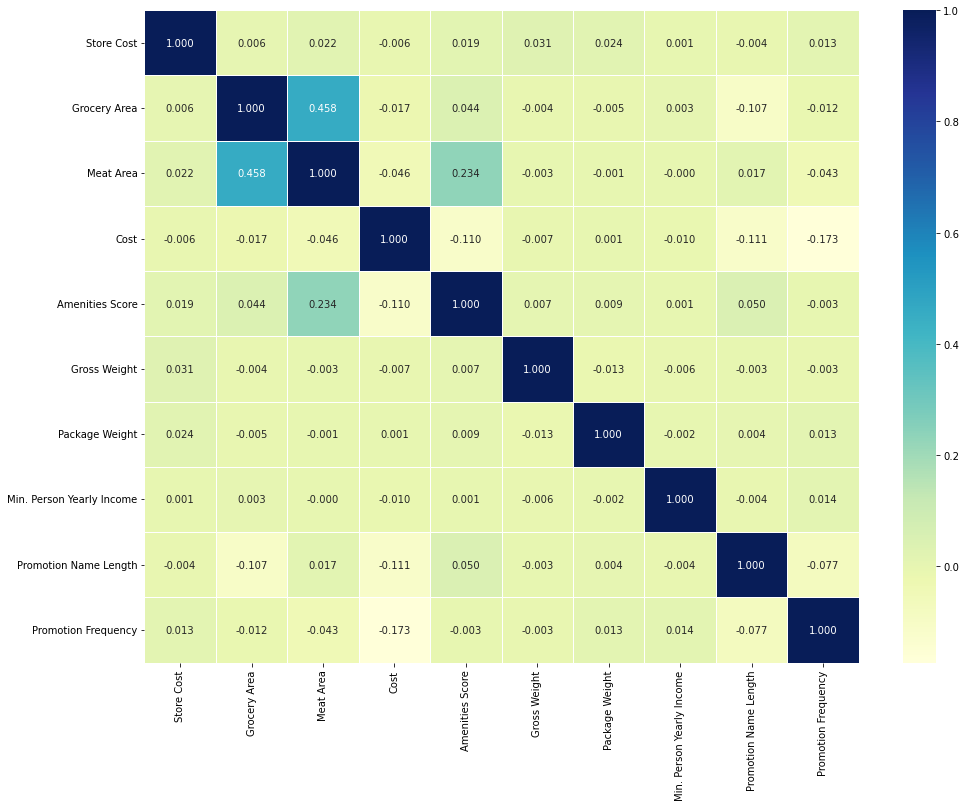

In [246]:
plt.figure(figsize=(16, 12)) 
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.3f', linewidths=0.5);

## Try Lazypredict

In [30]:
preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [31]:
reg = LazyRegressor(verbose=1,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train_transformed, X_test_transformed, y_train, y_test)

  2%|█▉                                                                                 | 1/42 [00:00<00:31,  1.29it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.11951398275585601, 'Adjusted R-Squared': 0.11575456905476011, 'RMSE': 148.32596671558767, 'Time taken': 0.7735717296600342}


  5%|███▉                                                                               | 2/42 [00:02<00:45,  1.14s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8860127607149402, 'Adjusted R-Squared': 0.88552606906882, 'RMSE': 53.368386578582395, 'Time taken': 1.3892617225646973}
{'Model': 'BayesianRidge', 'R-Squared': 0.016610610970420714, 'Adjusted R-Squared': 0.0124118304444093, 'RMSE': 156.75402992317584, 'Time taken': 0.07195925712585449}


 14%|███████████▊                                                                       | 6/42 [00:02<00:11,  3.27it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8199970267005273, 'Adjusted R-Squared': 0.8192284674834507, 'RMSE': 67.06497935689084, 'Time taken': 0.23787927627563477}
{'Model': 'DummyRegressor', 'R-Squared': -0.00035584667892929467, 'Adjusted R-Squared': -0.0046270689383662855, 'RMSE': 158.1004889993646, 'Time taken': 0.04496884346008301}
{'Model': 'ElasticNet', 'R-Squared': 0.013252880255355537, 'Adjusted R-Squared': 0.009039763216773133, 'RMSE': 157.02141601872205, 'Time taken': 0.08672118186950684}


 19%|███████████████▊                                                                   | 8/42 [00:03<00:09,  3.69it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.016423292249665544, 'Adjusted R-Squared': 0.012223711928368908, 'RMSE': 156.76895868208584, 'Time taken': 0.3812437057495117}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7617291382573985, 'Adjusted R-Squared': 0.7607117924680687, 'RMSE': 77.1598586830595, 'Time taken': 0.11893892288208008}


 21%|█████████████████▊                                                                 | 9/42 [00:10<01:16,  2.30s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9090683611318773, 'Adjusted R-Squared': 0.9086801100497148, 'RMSE': 47.666522041562914, 'Time taken': 7.6735968589782715}
{'Model': 'GammaRegressor', 'R-Squared': 0.011457117014007201, 'Adjusted R-Squared': 0.007236332599905748, 'RMSE': 157.16423128943975, 'Time taken': 0.07008194923400879}


 26%|████████████████████▋                                                          | 11/42 [28:39<3:14:41, 376.83s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.6229282729035965, 'Adjusted R-Squared': -4.646936506056005, 'RMSE': 374.83248972274265, 'Time taken': 1708.3506803512573}


 29%|██████████████████████▌                                                        | 12/42 [28:45<2:24:07, 288.25s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.4990932453487479, 'Adjusted R-Squared': 0.496954522325864, 'RMSE': 111.87534816230519, 'Time taken': 6.067062854766846}


 31%|████████████████████████▍                                                      | 13/42 [28:47<1:44:04, 215.31s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8495669732109444, 'Adjusted R-Squared': 0.8489246688802314, 'RMSE': 61.30946871684031, 'Time taken': 1.6547677516937256}


 33%|██████████████████████████▎                                                    | 14/42 [28:47<1:13:43, 157.98s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.014497162037611977, 'Adjusted R-Squared': 0.010289357712563452, 'RMSE': 156.92238329026972, 'Time taken': 0.29457855224609375}


 36%|████████████████████████████▉                                                    | 15/42 [28:51<51:56, 115.42s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': -0.02282660449464613, 'Adjusted R-Squared': -0.027193770213890467, 'RMSE': 159.86631476463396, 'Time taken': 3.6652843952178955}


 40%|█████████████████████████████████▏                                                | 17/42 [29:00<25:23, 60.94s/it]

KernelRidge model failed to execute
solve() got an unexpected keyword argument 'sym_pos'
{'Model': 'Lars', 'R-Squared': 0.01640006814545203, 'Adjusted R-Squared': 0.012200388664130313, 'RMSE': 156.77080947679957, 'Time taken': 0.17290091514587402}


 45%|█████████████████████████████████████                                             | 19/42 [29:01<11:43, 30.61s/it]

{'Model': 'LarsCV', 'R-Squared': 0.0157703376071886, 'Adjusted R-Squared': 0.011567969363561525, 'RMSE': 156.82098616280337, 'Time taken': 0.3627922534942627}
{'Model': 'Lasso', 'R-Squared': 0.015307594558051973, 'Adjusted R-Squared': 0.011103250539086118, 'RMSE': 156.85784711939942, 'Time taken': 0.10294318199157715}


 48%|███████████████████████████████████████                                           | 20/42 [29:01<07:57, 21.69s/it]

{'Model': 'LassoCV', 'R-Squared': 0.015941486782073744, 'Adjusted R-Squared': 0.011739849294574944, 'RMSE': 156.8073506515421, 'Time taken': 0.43175840377807617}
{'Model': 'LassoLars', 'R-Squared': -0.00035584667892929467, 'Adjusted R-Squared': -0.0046270689383662855, 'RMSE': 158.1004889993646, 'Time taken': 0.07295846939086914}


 55%|████████████████████████████████████████████▉                                     | 23/42 [29:02<02:50,  8.95s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.0157703376071886, 'Adjusted R-Squared': 0.011567969363561525, 'RMSE': 156.82098616280337, 'Time taken': 0.28983354568481445}
{'Model': 'LassoLarsIC', 'R-Squared': 0.015689610334281623, 'Adjusted R-Squared': 0.011486897409183294, 'RMSE': 156.82741731980443, 'Time taken': 0.1156306266784668}
{'Model': 'LinearRegression', 'R-Squared': 0.016958239597027136, 'Adjusted R-Squared': 0.012760943341970754, 'RMSE': 156.72632116134136, 'Time taken': 0.0659632682800293}


 60%|████████████████████████████████████████████████▊                                 | 25/42 [29:02<01:29,  5.29s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.0076711370410588176, 'Adjusted R-Squared': 0.003434187617288087, 'RMSE': 157.4649021148593, 'Time taken': 0.11540985107421875}


 62%|██████████████████████████████████████████████████▊                               | 26/42 [29:25<02:31,  9.45s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.10680464650140331, 'Adjusted R-Squared': 0.1029909677104468, 'RMSE': 149.3926336022615, 'Time taken': 23.552865743637085}


 64%|████████████████████████████████████████████████████▋                             | 27/42 [30:15<04:48, 19.22s/it]

{'Model': 'NuSVR', 'R-Squared': 0.022383755944963557, 'Adjusted R-Squared': 0.01820962503279111, 'RMSE': 156.29322779998782, 'Time taken': 49.20276403427124}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.01389100916049757, 'Adjusted R-Squared': 0.00968061674275189, 'RMSE': 156.9706349688812, 'Time taken': 0.05883502960205078}


 74%|████████████████████████████████████████████████████████████▌                     | 31/42 [30:15<01:18,  7.17s/it]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.015009637762740002, 'Adjusted R-Squared': 0.010804021556781174, 'RMSE': 156.8815770304926, 'Time taken': 0.15592503547668457}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.042870864067186876, 'Adjusted R-Squared': -0.04732361281965325, 'RMSE': 161.4251590281673, 'Time taken': 0.0743558406829834}
{'Model': 'PoissonRegressor', 'R-Squared': 0.016857724106845384, 'Adjusted R-Squared': 0.012659998680509155, 'RMSE': 156.7343335474659, 'Time taken': 0.1131901741027832}
QuantileRegressor model failed to execute
Unable to allocate 7.61 GiB for an array with shape (22581, 45212) and data type float64


 79%|████████████████████████████████████████████████████████████████▍                 | 33/42 [31:41<02:44, 18.28s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.6681428305704047, 'Adjusted R-Squared': -0.6752653048514383, 'RMSE': 204.16090042792646, 'Time taken': 0.695340633392334}


 81%|██████████████████████████████████████████████████████████████████▍               | 34/42 [31:55<02:17, 17.17s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8936103904877174, 'Adjusted R-Squared': 0.89315613846347, 'RMSE': 51.55912794850355, 'Time taken': 13.794043779373169}
Ridge model failed to execute
solve() got an unexpected keyword argument 'sym_pos'


 86%|██████████████████████████████████████████████████████████████████████▎           | 36/42 [31:55<01:00, 10.12s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.016930994688121537, 'Adjusted R-Squared': 0.012733582105398655, 'RMSE': 156.72849297383698, 'Time taken': 0.22087335586547852}


 88%|████████████████████████████████████████████████████████████████████████▏         | 37/42 [31:55<00:39,  7.87s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.014856167545086785, 'Adjusted R-Squared': 0.010649896066894593, 'RMSE': 156.8937983236798, 'Time taken': 0.2508566379547119}


 95%|██████████████████████████████████████████████████████████████████████████████    | 40/42 [32:49<00:22, 11.26s/it]

{'Model': 'SVR', 'R-Squared': 0.028270139909234437, 'Adjusted R-Squared': 0.024121142107743854, 'RMSE': 155.82198409355664, 'Time taken': 53.641679763793945}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.016958239597027136, 'Adjusted R-Squared': 0.012760943341970754, 'RMSE': 156.72632116134136, 'Time taken': 0.06357288360595703}
{'Model': 'TweedieRegressor', 'R-Squared': 0.011428067939245556, 'Adjusted R-Squared': 0.007207159494225346, 'RMSE': 157.16654046693913, 'Time taken': 0.08664321899414062}


 98%|████████████████████████████████████████████████████████████████████████████████  | 41/42 [32:51<00:09,  9.13s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.879312536051422, 'Adjusted R-Squared': 0.8787972364366264, 'RMSE': 54.914500358140096, 'Time taken': 1.8800573348999023}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 22581, number of used features: 24
[LightGBM] [Info] Start training from score 518.858765


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [32:52<00:00, 46.96s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.847738514486305, 'Adjusted R-Squared': 0.8470884031800732, 'RMSE': 61.680940496314996, 'Time taken': 0.7798466682434082}


In [32]:
print(models)

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          0.91       0.91  47.67   
RandomForestRegressor                        0.89       0.89  51.56   
BaggingRegressor                             0.89       0.89  53.37   
XGBRegressor                                 0.88       0.88  54.91   
HistGradientBoostingRegressor                0.85       0.85  61.31   
LGBMRegressor                                0.85       0.85  61.68   
DecisionTreeRegressor                        0.82       0.82  67.06   
ExtraTreeRegressor                           0.76       0.76  77.16   
GradientBoostingRegressor                    0.50       0.50 111.88   
AdaBoostRegressor                            0.12       0.12 148.33   
MLPRegressor                                 0.10       0.11 149.39   
SVR                                          0.02       0.03 155.82   
NuSVR 

## ExtraTreesRegressor

In [ ]:
# Preprocess the data by removing missing values and scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_transformed)
X_test = scaler.transform(X_test_transformed)

In [ ]:
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=24)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:

# Train an ExtraTreesRegressor model on the reduced dataset
exmodel = ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
exmodel.fit(X_train_pca, y_train)


In [ ]:
# Check if the model fitted well or not
predictions = exmodel.predict(X_train_pca)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

In [ ]:
# Evaluate the performance of the model on the testing set
y_pred = exmodel.predict(X_test_pca)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')

In [ ]:
# GridSearch for ExtraTree Regressor
params = {
    'n_estimators': range(100, 501, 100),
    'max_depth': [2, 8, 16, 32, 64],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2],
}

GS_EXTRA = GridSearchCV(
    ExtraTreesRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

GS_EXTRA.fit(X_train_transformed, y_train)

In [ ]:
GS_EXTRA.best_params_

In [ ]:
EXTRA = GS_EXTRA.best_estimator_
EXTRA

## RandomForestRegressor

In [15]:
# GridSearch for RandomForest Regressor
params = {
    'n_estimators': range(100, 501, 100),
    'max_depth': [2, 8, 16, 32, 64],
    'min_samples_split': [2,4,6],
    'min_samples_leaf': [1,2,3],
    # 'max_features': ["sqrt", "log2"] add 1 is the default
}

GS_RF = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

GS_RF.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 8, 16, 32, 64],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': range(100, 501, 100)},
             verbose=1)

In [16]:
GS_RF.best_params_

{'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [19]:
RF = GS_RF.best_estimator_
RF

RandomForestRegressor(max_depth=32, max_features='sqrt', n_estimators=500,
                      n_jobs=-1, random_state=42)

## BaggingRegressor

In [ ]:
# GridSearch for Bagging Regressor
params = {
    'n_estimators': range(100, 801, 20),
}

BAG_RF = GridSearchCV(
    BaggingRegressor(random_state=42, n_jobs=-1),
    param_grid=params,
    cv=3,
    n_jobs=-1,
    verbose=1
)

BAG_RF.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
BAG_RF.best_params_

In [ ]:
BAG = BAG_RF.best_estimator_
BAG

## XGBRegressor

In [22]:
model = make_pipeline(preprocessor, XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=12, min_split_loss=5))
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', Standar...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
 

In [23]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 52.29


In [ ]:
param_grid = {
    'xgbregressor__learning_rate': [0.01, 0.1],
    'xgbregressor__n_estimators': range(50, 501, 50),
    'xgbregressor__max_depth': [2, 4, 8, 16, 32],
    'xgbregressor__min_split_loss': range(0, 7, 2)
    
}


grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

In [ ]:
y_pred = grid_search.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
print(f'Best hyperparameters: {grid_search.best_params_}')

## LGBMRegressor

In [ ]:
# Preprocess the data by removing missing values and scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Apply pPCA to reduce the dimensionality of the data
ppca = PCA(n_components=10)
X_train_ppca = ppca.fit_transform(X_train)
X_test_ppca = ppca.transform(X_test)

In [24]:
model = make_pipeline(preprocessor, LGBMRegressor())
model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 22581, number of used features: 29
[LightGBM] [Info] Start training from score 518.858765


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Marriage', 'Gender',
                                                   'Is Recyclable?',
                                                   'Income Level',
                                                   'Price Tier']),
                                                 ('num', StandardScaler(),
                                                  Index(['Grocery Area', 'Meat Area', 'Gross Weight', 'Package Weight',
       'Min. Person Yearly Income', 'Family Expenses', 'Store Efficiency'],
      dtype='object'))

In [25]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 61.68


In [ ]:
param_grid = {
    'lgbmregressor__learning_rate': [0.01, 0.1],
    'lgbmregressor__n_estimators': range(50, 501, 50),
    'lgbmregressor__num_leaves': [31, 45, 61],
    'lgbmregressor__max_depth': [2, 4, 8, 16, 32],
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

In [161]:
y_pred = grid_search.predict(X_test_transformed)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse:.2f}')

In [ ]:
print(f'Best hyperparameters: {grid_search.best_params_}')

## Stacking & Boosting

In [33]:
rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

et = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

bag = make_pipeline(
    preprocessor,
    BaggingRegressor(n_estimators=75, n_jobs=-1, random_state=42)
)


#lr = LogisticRegression(random_state=0, max_iter=500, C = 10, penalty= 'l2', solver= 'newton-cg')

#mlp = MLPClassifier(random_state=0, hidden_layer_sizes = (512,) , max_iter=100, early_stopping=True,
              #      solver='adam', learning_rate = 'adaptive', alpha=0.001, activation='relu', batch_size=128)

#gb = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=100)

#hgb = HistGradientBoostingClassifier(random_state=0, learning_rate=0.01, l2_regularization=0.001)

#lgbm = LGBMClassifier(random_state=0, learning_rate=0.01, n_estimators=1000, num_leaves=10)

#cat = CatBoostClassifier(n_estimators=1500, learning_rate=0.05, random_state=0, eval_metric= 'MultiClass')

In [40]:
# Define the pipelines for each model
rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

et = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=512, max_depth=16, n_jobs=-1, random_state=42)
)

bag = make_pipeline(
    preprocessor,
    BaggingRegressor(n_estimators=75, n_jobs=-1, random_state=42)
)

xgb = make_pipeline(
    preprocessor,
    XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=8, random_state=42)
)

lgbm = make_pipeline(
    preprocessor,
    LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=8, random_state=42)
)

In [50]:
estimators_pca = [
              ('rf', rf),
              ('et', et),
              ('bag', bag),
              ('xgb', xgb),
              ('lgbm', lgbm)
             ]

stack_model = StackingRegressor(estimators=estimators, final_estimator=bag)

stack_model.fit(X_train, y_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [37]:
# Check if the model fitted well or not
predictions = stack_model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

32.003467789896284

In [38]:
# Check if the model fitted well or not
predictions = stack_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

52.91357827365574

In [37]:
estimators = [
              ('rf', rf),
              ('et', et),
              ('bag', bag),
             ]

voting_model = VotingRegressor(estimators=estimators, weights=[0.3, 1, 0.2])

voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(),
                                                                               Index(['Promotion Name', 'Store Kind', 'Degree', 'Work', 'Store Code',
       'Country ISO2', 'Order Brand', 'Order', 'Department', 'Income Level',
       'Price Tier'],
      dtype='object')),
                                                                              ('ohe',
                                                                               OneHotEncoder(),
                                                                               ['Marriage',
                                                                                'Gender',
                                                                              

In [38]:
# Check if the model fitted well or not
predictions = voting_model.predict(X_train)

mse = mean_squared_error(y_train, predictions)
rmse = np.sqrt(mse)
rmse

24.041391985513222

In [39]:
predictions = voting_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

47.91169884488162

## Optuna Optimization

In [37]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 32),
    }
    
    model = ExtraTreesRegressor(**params, n_jobs=-1, random_state=42)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scores=cross_val_score(model, X_train_transformed, y_train, cv=kf, scoring=rmse_scorer)
    positive_scores = (-scores).mean()


    return positive_scores

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-09-02 22:03:41,055] A new study created in memory with name: no-name-3055d8b8-0f16-447d-b8fd-353ad4cbbbc3
[I 2023-09-02 22:04:01,158] Trial 0 finished with value: 137.13294977144182 and parameters: {'n_estimators': 524, 'max_depth': 5}. Best is trial 0 with value: 137.13294977144182.
[I 2023-09-02 22:05:07,340] Trial 1 finished with value: 50.40120047242929 and parameters: {'n_estimators': 797, 'max_depth': 26}. Best is trial 1 with value: 50.40120047242929.
[I 2023-09-02 22:05:48,127] Trial 2 finished with value: 50.227880417511166 and parameters: {'n_estimators': 480, 'max_depth': 17}. Best is trial 2 with value: 50.227880417511166.
[I 2023-09-02 22:06:42,185] Trial 3 finished with value: 50.29874410584554 and parameters: {'n_estimators': 608, 'max_depth': 19}. Best is trial 2 with value: 50.227880417511166.
[I 2023-09-02 22:08:00,554] Trial 4 finished with value: 50.301167973490934 and parameters: {'n_estimators': 942, 'max_depth': 21}. Best is trial 2 with value: 50.2278804

KeyboardInterrupt: 

In [ ]:
# Print the best hyperparameters and corresponding RMSE
print("Best trial:")
trial = study.best_trial
print("Value (RMSE): {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Extract submissions

In [247]:
samples = pd.read_csv('data/sample_submission.csv')
samples.head()

,ID,Cost
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [252]:
test = pd.read_csv("data/test_data_cleaned.csv")
test.head()

,Promotion Name,Store Kind,Store Sales,Store Cost,Is Recyclable?,Store Area,Grocery Area,Frozen Area,Meat Area,Degree Work,...,Store Code,Country ISO2,Order Brand,Order,Department,Amenities Score,Gross Weight,Net Weight,Package Weight,Min. Person Yearly Income
0,Fantastic Discounts,Gourmet,11760000.00,4704000.00,yes,2201.06,1424.85,465.54,308.73,partial high school working as skilled manual,...,B06ls,CA,Gulf Coast,Candy,Snacks,5,31.83,28.78,3.05,50000.00
1,Bag Stuffer,Deluxe,2160000.00,669600.00,no,2577.16,1735.17,505.07,336.59,graduate degree working as professional,...,S01em,OR,Golden,Vegetables,Frozen Foods,5,29.94,27.04,2.91,70000.00
2,Pick Your Savings,Deluxe,1830000.00,823500.00,no,2837.58,2038.11,481.98,321.26,partial high school working as management,...,H11go,ZA,Club,Dairy,Dairy,5,29.22,26.31,2.91,130000.00
3,Price Winners,Deluxe,8820000.00,4410000.00,no,2859.04,1871.16,593.93,394.58,partial high school working as manual,...,M10da,YU,Imagine,Frozen Desserts,Frozen Foods,5,28.05,25.00,3.05,10000.00
4,Dollar Days,Supermarket,4320000.00,1987200.00,no,2193.97,1320.15,523.32,348.85,high school degree working as manual,...,L05es,CA,BBB Best,Hot Beverages,Beverages,1,23.55,20.64,2.91,30000.00


In [259]:
test.isna().sum()

Promotion Name               0
Store Kind                   0
Store Cost                   0
Is Recyclable?               0
Grocery Area                 0
Meat Area                    0
Degree Work                  0
Marriage                     0
Gender                       0
Children                     0
Degree                       0
Work                         0
Store Code                   0
Country ISO2                 0
Order Brand                  0
Order                        0
Department                   0
Amenities Score              0
Gross Weight                 0
Package Weight               0
Min. Person Yearly Income    0
Store CountryISO2            0
Income Level                 0
Promotion Name Length        0
Promotion Frequency          0
dtype: int64

In [260]:
y_sub_pred = exmodel.predict(test)

In [261]:
samples["Cost"] = y_sub_pred

In [262]:
samples.to_csv("data/submission.csv", index=False)